In [204]:
import tensorflow as tf
import pandas as pd
from window import WindowGenerator
from utils import train_test_val_split

# LSTM

## Datasets

In [205]:
case_1 = pd.read_csv("../datasets/case_1.csv")
case_2 = pd.read_csv("../datasets/case_2.csv")
case_3 = pd.read_csv("../datasets/case_3.csv")
case_4 = pd.read_csv("../datasets/case_4.csv")
case_5 = pd.read_csv("../datasets/case_5.csv")

In [206]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

num_features = len(label_columns)

In [207]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Train case function

In [208]:
def train_case(case_df:pd.DataFrame, model, in_width:int, out_steps:int, max_epochs:int):
    """ Train model for given case dataframe. """

    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = train_test_val_split(case_df)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

In [209]:
def plot_losses(history):
    losses = pd.DataFrame(history.history)

    losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")
    losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")
    

## Model creation

In [210]:
IN_WIDTH = 8
OUT_STEPS = 8
MAX_EPOCHS = 150
features_size = len(label_columns)

In [211]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [212]:
multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                         optimizer=tf.optimizers.Adam(),
                         metrics=[tf.metrics.RootMeanSquaredError()])

## Case 1

In [213]:
window, history = train_case(
    case_df=case_1,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

2022-08-30 15:52:52.203344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 15:52:52.393706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 15:52:52.502079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 15:52:53.058250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 15:52:53.125272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [214]:
multi_lstm_model.build(input_shape=window.example[0].shape)
multi_lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                39040     
                                                                 
 dense_7 (Dense)             (None, 1088)              35904     
                                                                 
 reshape_7 (Reshape)         (None, 8, 136)            0         
                                                                 
Total params: 74,944
Trainable params: 74,944
Non-trainable params: 0
_________________________________________________________________


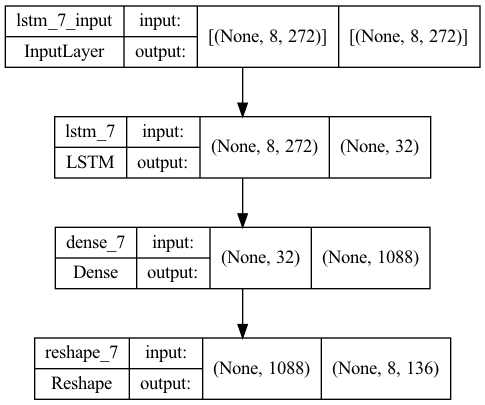

In [215]:
tf.keras.utils.plot_model(multi_lstm_model, "../plots/models/multi_lstm_model.png", show_shapes=True)

label_col_index 135


2022-08-30 15:53:55.136408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-30 15:53:55.189786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


label_col_index 135
label_col_index 135


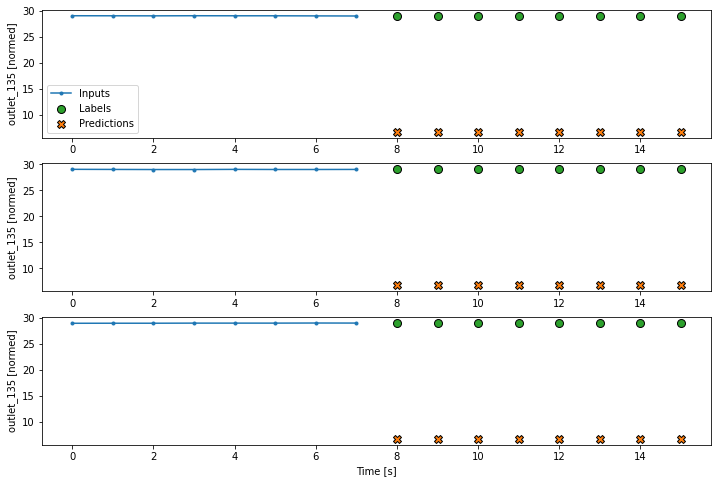

In [216]:
window.plot(multi_lstm_model, plot_col="outlet_135")

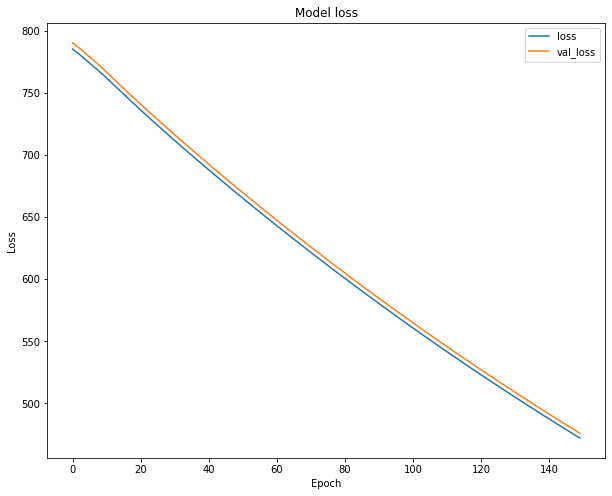

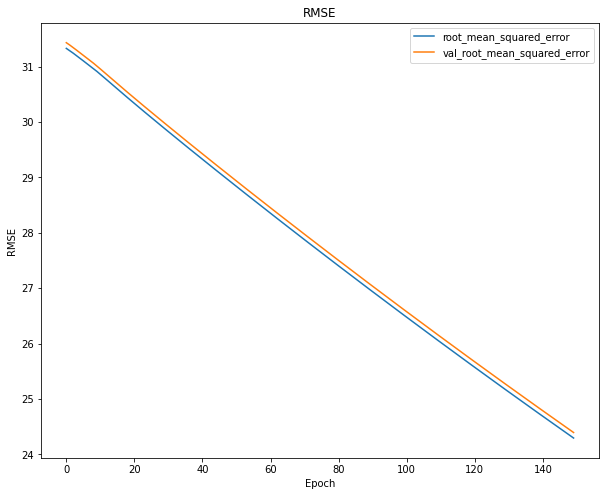

In [217]:
plot_losses(history=history)

In [218]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 257ms/step - loss: 475.5793 - root_mean_squared_error: 24.3910


[475.57928466796875, 24.3909912109375]

## Case 2

In [219]:
window, history = train_case(
    case_df=case_2,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


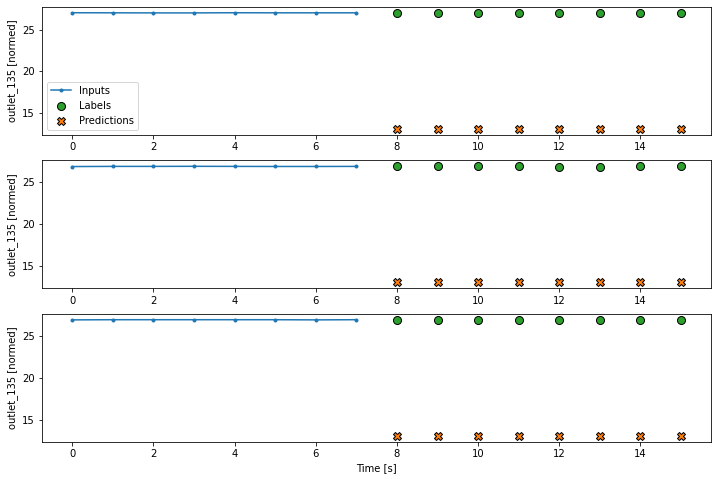

In [220]:
window.plot(multi_lstm_model, plot_col="outlet_135")

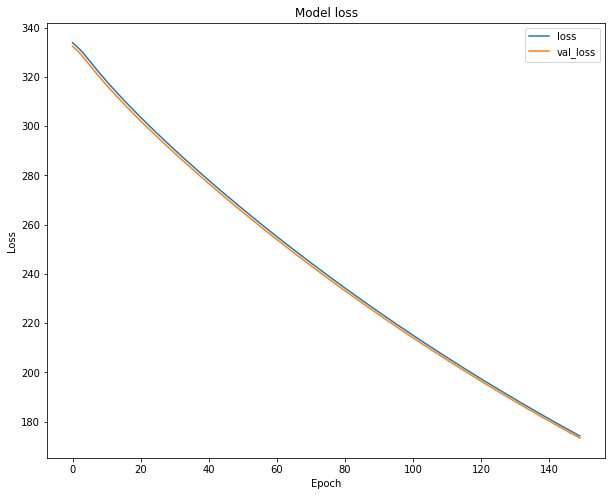

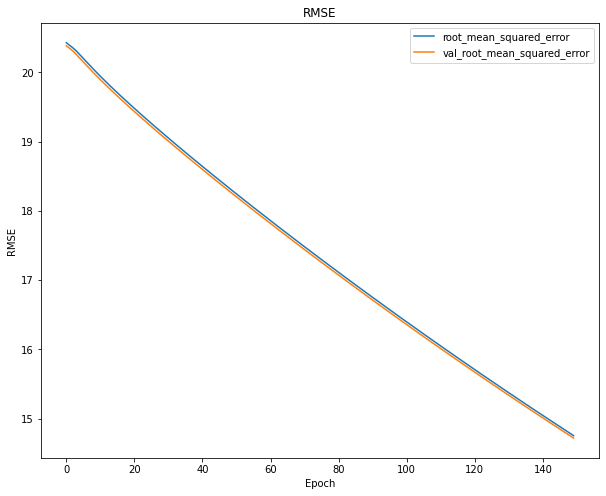

In [221]:
plot_losses(history=history)

In [222]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 282ms/step - loss: 174.9966 - root_mean_squared_error: 14.7904


[174.99655151367188, 14.79037857055664]

## Case 3

In [223]:
window, history = train_case(
    case_df=case_3,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


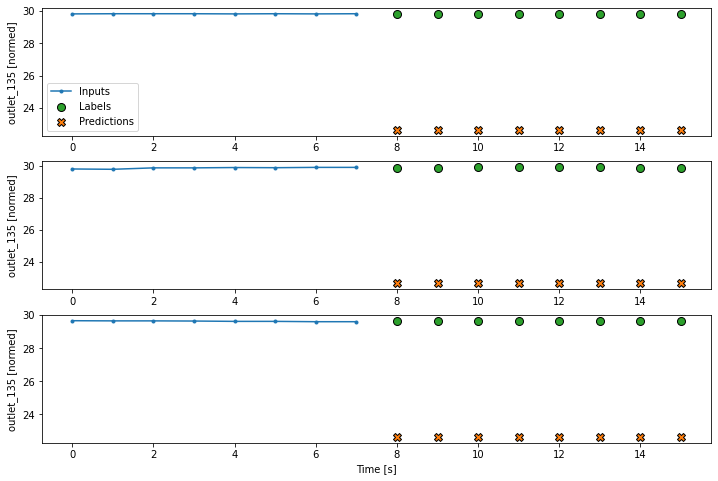

In [224]:
window.plot(multi_lstm_model, plot_col="outlet_135")

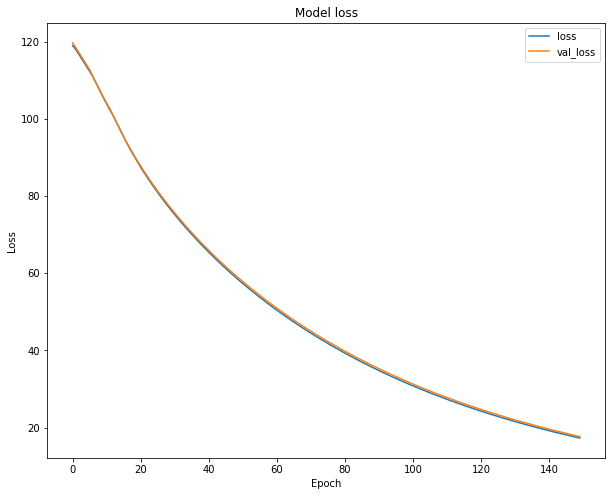

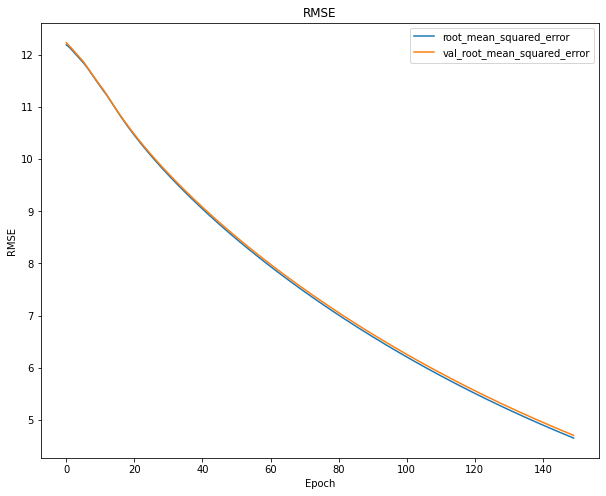

In [225]:
plot_losses(history=history)

In [226]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 268ms/step - loss: 17.4147 - root_mean_squared_error: 4.6582


[17.41473960876465, 4.6582255363464355]

## Case 4

In [227]:
window, history = train_case(
    case_df=case_4,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


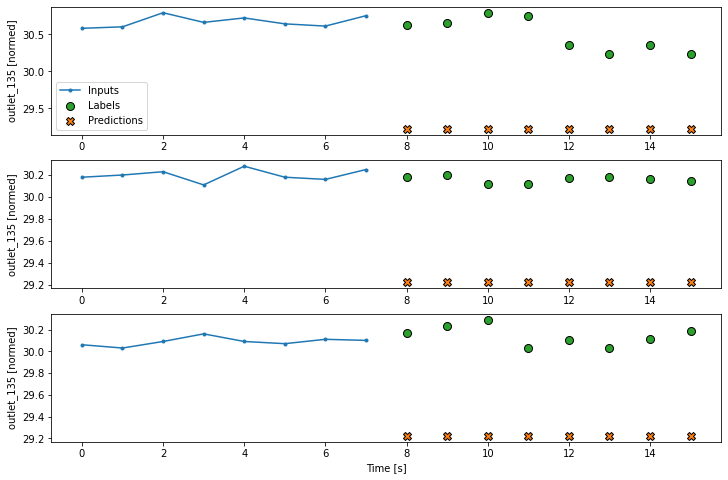

In [228]:
window.plot(multi_lstm_model, plot_col="outlet_135")

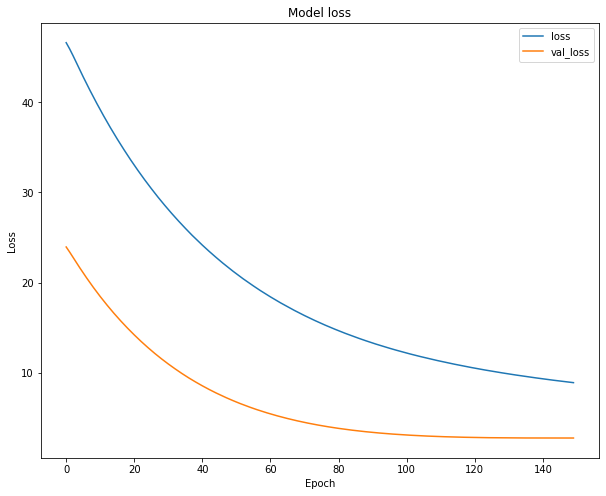

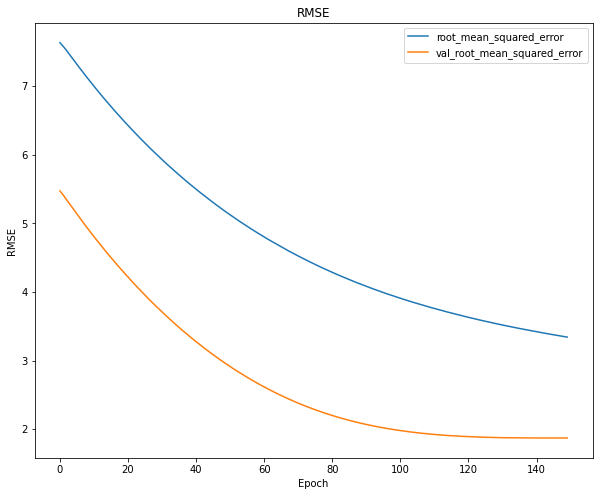

In [229]:
plot_losses(history=history)

In [230]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 264ms/step - loss: 2.7961 - root_mean_squared_error: 1.8660


[2.7960617542266846, 1.8660013675689697]

## Case 5

In [231]:
window, history = train_case(
    case_df=case_5,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


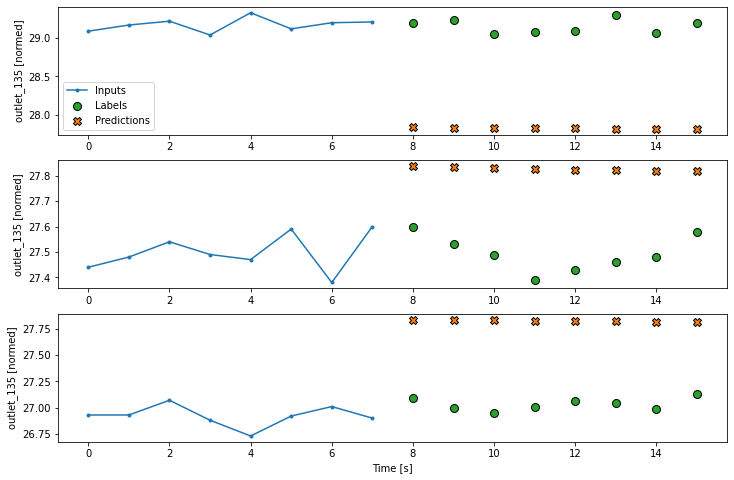

In [232]:
window.plot(multi_lstm_model, plot_col="outlet_135")

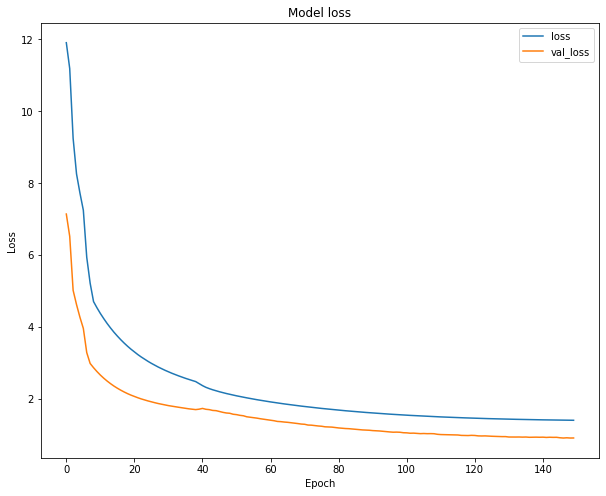

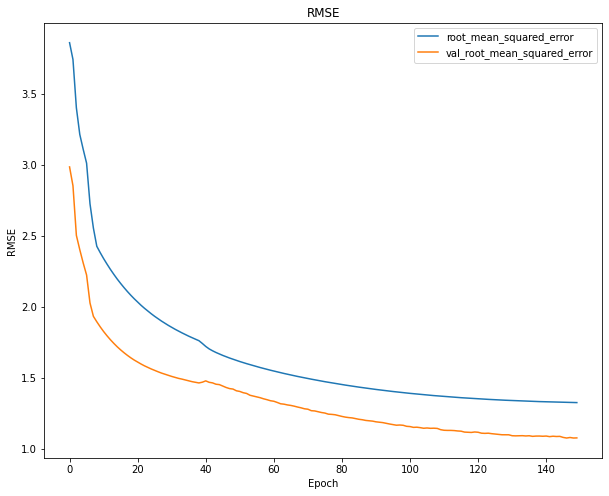

In [233]:
plot_losses(history=history)

In [234]:
multi_lstm_model.evaluate(window.test)

2/2 [==============================] - 0s 6ms/step - loss: 1.9861 - root_mean_squared_error: 1.5802


[1.9861245155334473, 1.5801693201065063]